In [1]:
import os
import re
import numpy as np
import scipy

# Tensorflow.
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models

# Preprocessing layers.
from kapre.time_frequency import STFT, Magnitude

# Audio data augmentation.
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

# Set the seed value for experiment reproducibility.
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

# Plotting.
import matplotlib.pyplot as plt

# Play audio. 
from IPython.display import Audio

In [2]:
# Load dataset.
audio_clips_folder = "./data/clips/"

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    audio_clips_folder,
    batch_size=2,
    validation_split=0.25,
    seed=0,
    output_sequence_length=None,
    subset="both"
)

class_names = np.array(train_ds.class_names)
print()
print("label names: ", class_names)

Found 12 files belonging to 3 classes.
Using 9 files for training.
Using 3 files for validation.

label names:  ['_silence_' 'knock_ironlocker' 'knock_tabletop']


In [3]:
# Drop dimension for mono channel audios.
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

(2, 34816)


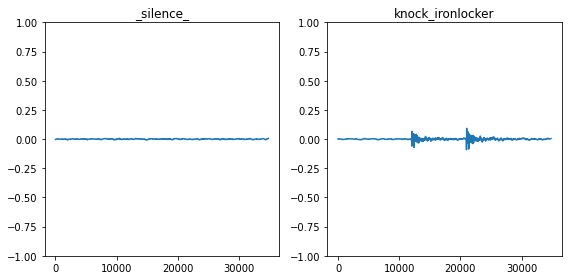

In [4]:
# Check data.
for example_audios, example_labels in train_ds.take(1):
    break
print(example_audios.shape)

fig, axes = plt.subplots(nrows=1, ncols=len(example_audios), figsize=(8, 4))
for idx, ax in enumerate(axes):
    ax.set_ylim([-1, 1])
    ax.plot(example_audios[idx])
    ax.set_title(class_names[example_labels[idx]])
fig.tight_layout()

In [5]:
# Data augmentation. 
# Init pipeline.
augmentations_pipeline = Compose(
    [
        Shift(min_fraction=-0.3, max_fraction=0.3, p=1.0, rollover=False),
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.005, p=0.5),
        # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        Gain(min_gain_in_db=-3.0, max_gain_in_db=12.0, p=0.5),
    ]
)

def apply_pipeline(y, sr):
    shifted = augmentations_pipeline(y, sr)
    return shifted


@tf.function
def tf_apply_pipeline(feature, sr, ):
    """
    Applies the augmentation pipeline to audio files
    @param y: audio data
    @param sr: sampling rate
    @return: augmented audio data
    """
    augmented_feature = tf.numpy_function(
        apply_pipeline, inp=[feature, sr], Tout=tf.float32, name="apply_pipeline"
    )

    return augmented_feature, sr


def augment_audio_dataset(dataset: tf.data.Dataset):
    dataset = dataset.map(tf_apply_pipeline)
    return dataset

# Apply audio augmentation.
train_ds_augmented = augment_audio_dataset(train_ds)
train_ds_augmented = train_ds_augmented.map(lambda y, sr: (tf.expand_dims(y, axis=-1), sr))
print(train_ds)
print(train_ds_augmented)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


(2, 34816, 1)


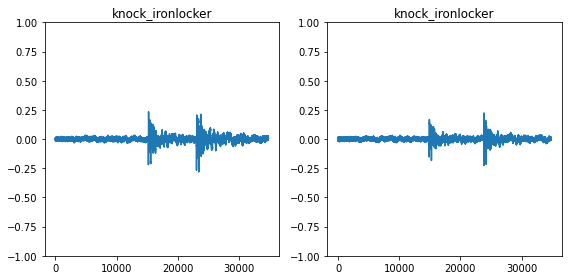

In [6]:
# Check data.
for example_audios, example_labels in train_ds_augmented.take(1):
    break
print(example_audios.shape)
    
fig, axes = plt.subplots(nrows=1, ncols=len(example_audios), figsize=(8, 4))
for idx, ax in enumerate(axes):
    ax.set_ylim([-1, 1])
    ax.plot(example_audios[idx])
    ax.set_title(class_names[example_labels[idx]])
fig.tight_layout()

In [7]:
# Make spectrogram datasets.
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=1024, frame_step=512)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram

def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)
train_spectrogram_ds = make_spec_ds(train_ds_augmented)
val_spectrogram_ds = make_spec_ds(val_ds)

(2, 34816, 0, 513, 1)


C:\Users\unime\AppData\Local\Temp/ipykernel_41972/1642034253.py:9: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(example_spectrograms[idx, :, :, 0])


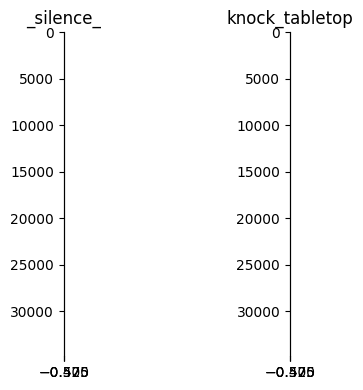

In [8]:
# Check spectrograms. 
for example_spectrograms, exmaple_labels in train_spectrogram_ds.take(1):
    break
print(example_spectrograms.shape)
    
fig, axes = plt.subplots(nrows=1, ncols=len(example_spectrograms), dpi=100)
for idx, ax in enumerate(axes):
    # ax.set_ylim([-1, 1])
    ax.imshow(example_spectrograms[idx, :, :, 0])
    ax.set_title(class_names[exmaple_labels[idx]])
fig.tight_layout()

In [9]:
# Build model.
for example_spectrograms, exmaple_labels in train_spectrogram_ds.take(1):
    break
for examples_audios, examples_labels in train_ds_augmented.take(1):
    break
# input_shape = example_spectrograms.shape[1:]
input_shape = example_audios.shape[1:]
print('Input shape:', input_shape)
num_categories = len(class_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Compute spectrogram.
    STFT(n_fft=1024, win_length=1024, hop_length=512, 
         input_data_format="channels_last",
         output_data_format="channels_last"),
    Magnitude(),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    # norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    # layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_categories),
    layers.Softmax()
])

model.summary()

Input shape: (34816, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stft (STFT)                 (None, 67, 513, 1)        0         
                                                                 
 magnitude (Magnitude)       (None, 67, 513, 1)        0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                

In [10]:
# Config model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [11]:
# Training.
EPOCHS = 100
history = model.fit(
    # train_spectrogram_ds,
    train_ds_augmented,
    # validation_data=val_spectrogram_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
5/5 [==============================] - 5s 96ms/step - loss: 1.2010 - accuracy: 0.2222 - val_loss: 1.1174 - val_accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 33ms/step - loss: 1.2193 - accuracy: 0.4444 - val_loss: 1.1012 - val_accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 31ms/step - loss: 1.0743 - accuracy: 0.4444 - val_loss: 1.0907 - val_accuracy: 0.3333
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 1.0696 - accuracy: 0.3333 - val_loss: 1.0816 - val_accuracy: 0.3333
Epoch 5/100
5/5 [==============================] - 0s 32ms/step - loss: 1.0399 - accuracy: 0.4444 - val_loss: 1.0804 - val_accuracy: 0.3333
Epoch 6/100
5/5 [==============================] - 0s 33ms/step - loss: 1.0106 - accuracy: 0.5556 - val_loss: 1.0765 - val_accuracy: 0.3333
Epoch 7/100
5/5 [==============================] - 0s 32ms/step - loss: 0.8854 - accuracy: 0.6667 - val_loss: 1.0755 - val_accuracy: 0.3333
Epoch 8/100


Text(0, 0.5, 'Accuracy [%]')

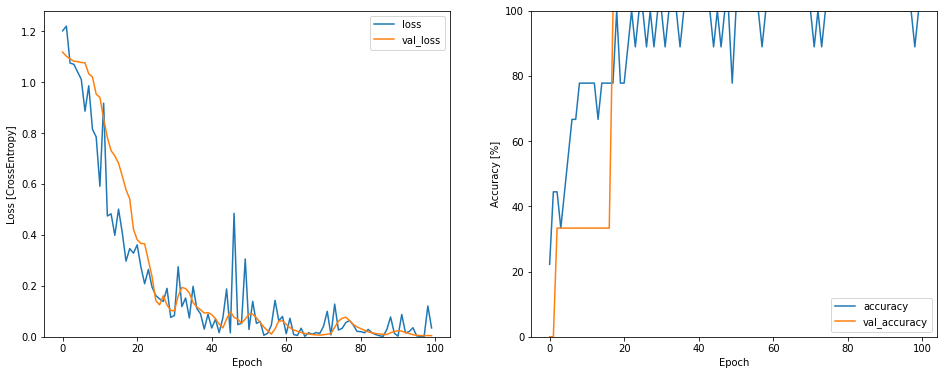

In [12]:
# Plot trainning history.
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [13]:
model.evaluate(val_ds, return_dict=True)

2/2 [==============================] - 0s 18ms/step - loss: 0.0046 - accuracy: 1.0000


{'loss': 0.004600902553647757, 'accuracy': 1.0}

In [14]:
# Prediting stream.
# Stream file.
# audio_filename = "./data/raw/knock_ironlocker.wav"
audio_filename = "./data/raw/knock_tabletop.wav"
audio = tfio.audio.AudioIOTensor(audio_filename)
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_float = audio_tensor / (2**15)

# Parameters. 
sampling_rate = audio.rate.numpy()
window_size = 34816
stride_sec = 1.0
stride_size = int(sampling_rate * stride_sec)

# Sliding window.
frames = tf.signal.frame(audio_float, frame_length=window_size, frame_step=stride_size, pad_end=True, pad_value=0)
frames = tf.expand_dims(frames, axis=-1)
# Calculate spectrogram.
# spectrogram = get_spectrogram(frames)

# Run prediction.
# predictions = model.predict(tf.expand_dims(spectrogram, axis=0))
# predictions = model.predict(spectrogram)
predictions = model.predict(frames)
outputs = class_names[tf.argmax(predictions, axis=-1)]
print(outputs)

1/1 [==============================] - 0s 189ms/step
['_silence_' 'knock_tabletop' '_silence_' 'knock_tabletop' '_silence_'
 '_silence_' 'knock_tabletop' '_silence_' '_silence_' 'knock_tabletop'
 '_silence_']


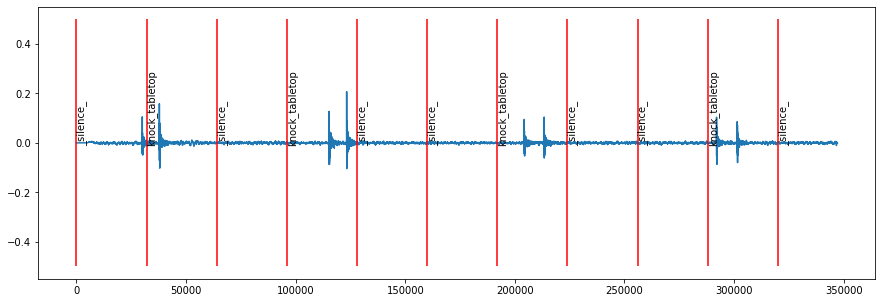

In [15]:
# Plot results.
fig, ax = plt.subplots(figsize=(15, 5))

# Plot waveform.
ax.plot(audio_float.numpy())

# Plot segmentations.
start_index_arr = np.arange(0, len(audio_float), stride_size, dtype=int)
ax.vlines(start_index_arr, ymin=-0.5, ymax=0.5, color="red")

# Adding labels.
for idx, output in enumerate(outputs):
    ax.text(start_index_arr[idx], 0, output, rotation="vertical")

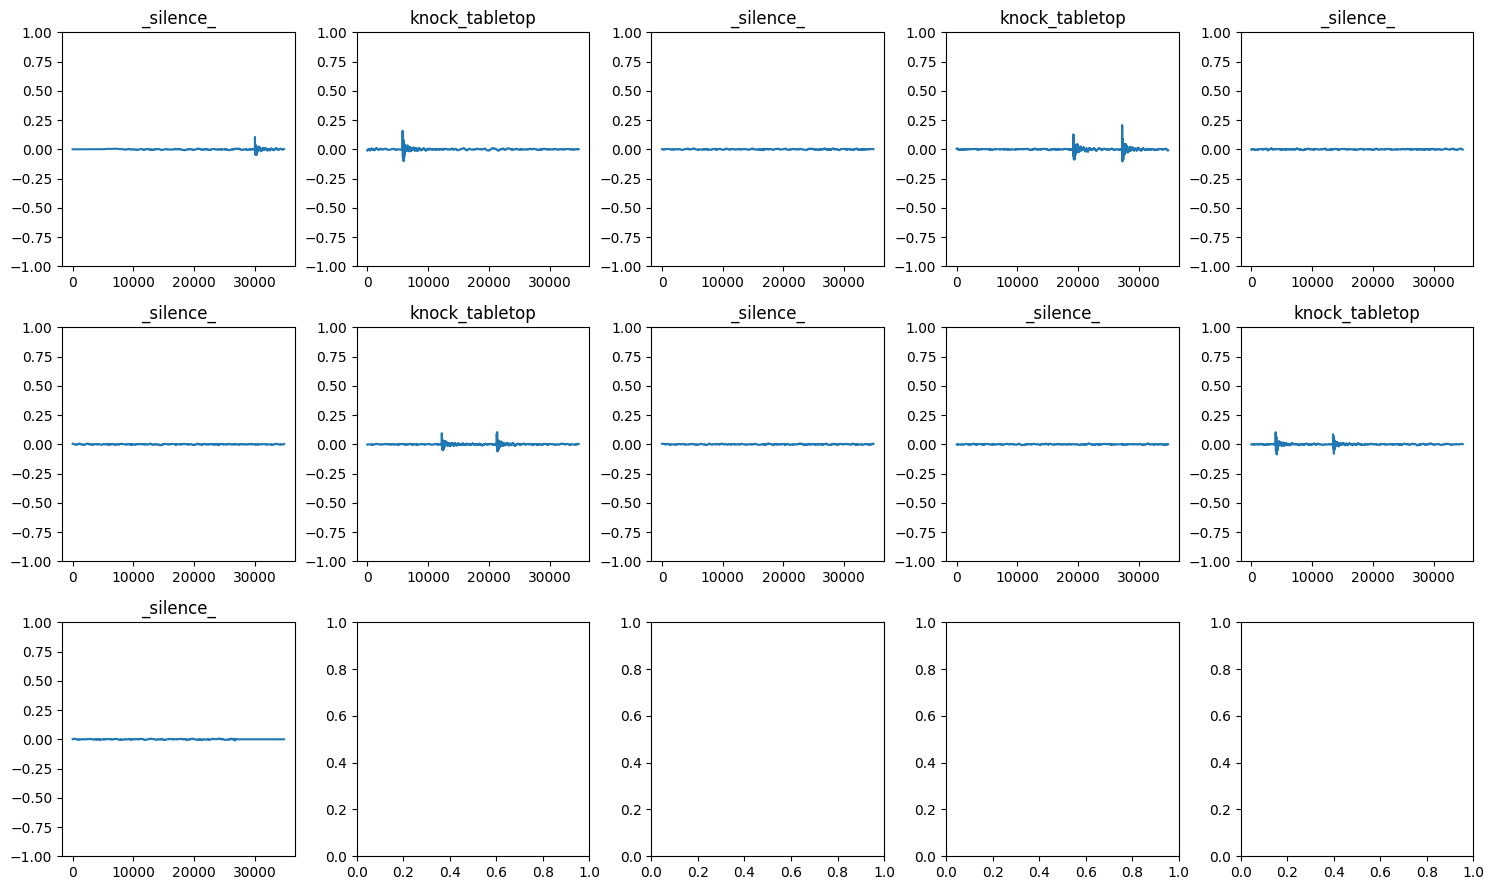

In [16]:
# Show all slices. 
ncols = 5
nrows = int(np.ceil(frames.shape[0] / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3), dpi=100)
axes = axes.flatten()
for idx, frame in enumerate(frames):
    # set axis.
    ax = axes[idx]
    ax.set_ylim([-1, 1])
    ax.set_title(outputs[idx])
    ax.plot(frame)
fig.tight_layout()

In [17]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
MODEL_DIR = "./model/"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = ./model/1



INFO:tensorflow:Assets written to: ./model/1\assets


INFO:tensorflow:Assets written to: ./model/1\assets



Saved model:


In [18]:
with open("./data/sample.txt", "w") as f:
    f.write(str(frames[1].numpy().tolist()))